# 개선된 U-Net 모델 만들기

## Step 1. KITTI 데이터셋 수집과 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [2]:
# 데이터셋 가져오기
!mkdir -p ~/aiffel/semantic_segmentation/data
!ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/

ln: failed to create symbolic link '/aiffel/aiffel/semantic_segmentation/data/testing': File exists
ln: failed to create symbolic link '/aiffel/aiffel/semantic_segmentation/data/training': File exists


### 데이터 로더(data loader) 만들기

In [3]:
# Augmentation, Resize
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터
                Resize(                # 입력이미지를 224X224로 resize
                    width=224,
                    height=224
                    )
                ])

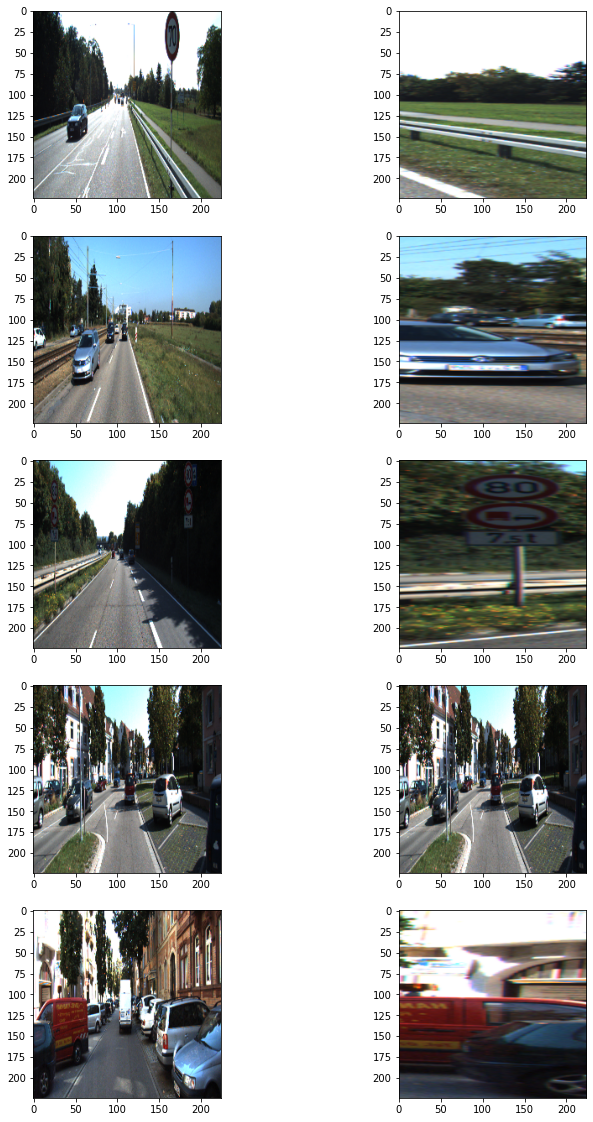

In [4]:
# 이미지 불러오기
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋 5개에 augmentation 적용해보기
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
# 데이터셋 구성하기(tf.keras.utils.Sequence를 상속받은 generator 형태)
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받는다.
  KittiDataset을 원하는 방식으로 preprocess하기 위해 Sequnce를 커스텀해 사용한다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path
    batch_size: batch_size
    img_size: preprocess에 사용할 입력이미지의 크기
    output_size: ground_truth를 만들어주기 위한 크기
    is_train: Generator가 학습용인지 테스트용인지 구분
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받기
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지 확인
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    # is_train에 따라 test set을 분리해서 load 해야한다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력 만들기
    # 입력은 resize및 augmentation이 적용된 input image
    # 출력은 semantic label
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle하도록 적용.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [6]:
# 위의 함수들 적용하기
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net 모델의 구현
### 모델 구조 만들기

![unet](https://user-images.githubusercontent.com/116326867/215251103-6e0f473c-68ba-455e-bea3-fa91a16ece4a.png)

In [7]:
def unet_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기

In [8]:
unet_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unet_model = unet_model()
unet_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_unet = unet_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_model.save(unet_model_path)  #학습한 모델 저장하기

Epoch 1/100
11/11 [==============================] - 26s 694ms/step - loss: 0.6861 - val_loss: 0.6749
Epoch 2/100
11/11 [==============================] - 7s 673ms/step - loss: 0.5089 - val_loss: 0.0524
Epoch 3/100
11/11 [==============================] - 7s 642ms/step - loss: 0.0314 - val_loss: 0.0374
Epoch 4/100
11/11 [==============================] - 7s 623ms/step - loss: 0.0423 - val_loss: 0.0383
Epoch 5/100
11/11 [==============================] - 7s 615ms/step - loss: 0.0357 - val_loss: 0.0373
Epoch 6/100
11/11 [==============================] - 7s 611ms/step - loss: 0.0272 - val_loss: 0.0329
Epoch 7/100
11/11 [==============================] - 7s 609ms/step - loss: 0.0302 - val_loss: 0.0278
Epoch 8/100
11/11 [==============================] - 7s 605ms/step - loss: 0.0245 - val_loss: 0.0268
Epoch 9/100
11/11 [==============================] - 7s 606ms/step - loss: 0.0269 - val_loss: 0.0302
Epoch 10/100
11/11 [==============================] - 7s 607ms/step - loss: 0.0263 - val_l

11/11 [==============================] - 7s 613ms/step - loss: 0.0146 - val_loss: 0.0205
Epoch 82/100
11/11 [==============================] - 7s 613ms/step - loss: 0.0140 - val_loss: 0.0199
Epoch 83/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0152 - val_loss: 0.0202
Epoch 84/100
11/11 [==============================] - 7s 610ms/step - loss: 0.0171 - val_loss: 0.0208
Epoch 85/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0182 - val_loss: 0.0212
Epoch 86/100
11/11 [==============================] - 7s 611ms/step - loss: 0.0175 - val_loss: 0.0204
Epoch 87/100
11/11 [==============================] - 7s 612ms/step - loss: 0.0181 - val_loss: 0.0198
Epoch 88/100
11/11 [==============================] - 7s 613ms/step - loss: 0.0152 - val_loss: 0.0210
Epoch 89/100
11/11 [==============================] - 7s 610ms/step - loss: 0.0168 - val_loss: 0.0191
Epoch 90/100
11/11 [==============================] - 7s 608ms/step - loss: 0.0172 - val_loss: 

## Step 3. U-Net++ 모델의 구현
### 모델 구조 만들기
![unetplusplus](https://user-images.githubusercontent.com/116326867/215288065-b6f5722a-bbee-4c06-b6dd-10a032f9c1e0.png)
- U-Net++ 관련 논문1 : [v1](https://arxiv.org/pdf/1807.10165.pdf)  
- U-Net++ 관련 논문2 : [v2](https://arxiv.org/pdf/1912.05074.pdf)  
- U-Net++ 구현 코드 : [build_xnet](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/builder.py#L12)  
- up_block 방식 : [Transpose2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L53) / [Upsample2D_block](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/segmentation_models/xnet/blocks.py#L28)  
- loss function : binary cross-entropy와 dice coefficient를 사용 -> [dice coefficient](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)

In [18]:
def unet_pp_model(input_shape=(224, 224, 3), deep_supervision=True, batch_size=4):
    inputs = Input(input_shape)
    
    # Backbone
    conv0_0 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)

    conv1_0 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool0_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)

    conv2_0 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool1_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)

    conv3_0 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool2_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)

    conv4_0 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool3_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    


    # 첫번째 대각선
    conv_up1_0 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv1_0)
    merge0_1 = concatenate([conv_up1_0, conv0_0], axis=3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_1)
    
    conv_up2_0 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv2_0)
    merge1_1 = concatenate([conv_up2_0, conv1_0], axis=3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_1)

    conv_up3_0 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv3_0)
    merge2_1 = concatenate([conv_up3_0, conv2_0], axis=3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_1)

    conv_up4_0 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv4_0)
    merge3_1 = concatenate([conv_up4_0, conv3_0], axis=3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3_1)
    


    # 두번째 대각선
    conv_up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv1_1)
    merge0_2 = concatenate([conv_up1_1, conv0_0, conv0_1], axis=3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_2)
    
    conv_up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv2_1)
    merge1_2 = concatenate([conv_up2_1, conv1_0, conv1_1], axis=3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_2)

    conv_up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv3_1)
    merge2_2 = concatenate([conv_up3_1, conv2_0, conv2_1], axis=3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_2)
    


    # 세번째 대각선
    conv_up1_2 = Conv2DTranspose(64, 2, strides = (2, 2), activation = 'relu', kernel_initializer='he_normal')(conv1_2)
    merge0_3 = concatenate([conv_up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_3)
    
    conv_up2_2 = Conv2DTranspose(128, 2, strides = (2, 2), activation = 'relu', kernel_initializer='he_normal')(conv2_2)
    merge1_3 = concatenate([conv_up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_3)
    


    # 네번째 대각선
    conv_up1_3 = Conv2DTranspose(64, 2, strides = (2, 2), activation = 'relu', kernel_initializer='he_normal')(conv1_3)
    merge0_4 = concatenate([conv_up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis=3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_4)
    
    # deep_supervision
    output1 = Conv2D(1, 1, activation='sigmoid', name = 'output1')(conv0_1)
    output2 = Conv2D(1, 1, activation='sigmoid', name = 'output2')(conv0_2)
    output3 = Conv2D(1, 1, activation='sigmoid', name = 'output3')(conv0_3)
    output4 = Conv2D(1, 1, activation='sigmoid', name = 'output4')(conv0_4)
    
    model = Model(inputs=inputs, outputs=output4)

    return model

In [19]:
# loss function
from keras import backend as K

def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [20]:
unet_pp_model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet_pp.h5'

unet_pp_model = unet_pp_model()
unet_pp_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_unet_pp = unet_pp_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_pp_model.save(unet_pp_model_path)  #학습한 모델 저장하기

Epoch 1/100
11/11 [==============================] - 15s 1s/step - loss: 0.6832 - val_loss: 0.6655
Epoch 2/100
11/11 [==============================] - 14s 1s/step - loss: 0.6361 - val_loss: 0.5612
Epoch 3/100
11/11 [==============================] - 13s 1s/step - loss: 0.3566 - val_loss: 0.0525
Epoch 4/100
11/11 [==============================] - 13s 1s/step - loss: 0.0383 - val_loss: 0.0354
Epoch 5/100
11/11 [==============================] - 12s 1s/step - loss: 0.0275 - val_loss: 0.0291
Epoch 6/100
11/11 [==============================] - 13s 1s/step - loss: 0.0264 - val_loss: 0.0397
Epoch 7/100
11/11 [==============================] - 13s 1s/step - loss: 0.0295 - val_loss: 0.0282
Epoch 8/100
11/11 [==============================] - 13s 1s/step - loss: 0.0299 - val_loss: 0.0327
Epoch 9/100
11/11 [==============================] - 13s 1s/step - loss: 0.0279 - val_loss: 0.0269
Epoch 10/100
11/11 [==============================] - 13s 1s/step - loss: 0.0307 - val_loss: 0.0416
Epoch 11/

11/11 [==============================] - 13s 1s/step - loss: 0.0089 - val_loss: 0.0189
Epoch 91/100
11/11 [==============================] - 13s 1s/step - loss: 0.0090 - val_loss: 0.0192
Epoch 92/100
11/11 [==============================] - 13s 1s/step - loss: 0.0084 - val_loss: 0.0221
Epoch 93/100
11/11 [==============================] - 13s 1s/step - loss: 0.0111 - val_loss: 0.0187
Epoch 94/100
11/11 [==============================] - 13s 1s/step - loss: 0.0108 - val_loss: 0.0173
Epoch 95/100
11/11 [==============================] - 13s 1s/step - loss: 0.0090 - val_loss: 0.0191
Epoch 96/100
11/11 [==============================] - 13s 1s/step - loss: 0.0098 - val_loss: 0.0189
Epoch 97/100
11/11 [==============================] - 13s 1s/step - loss: 0.0136 - val_loss: 0.0209
Epoch 98/100
11/11 [==============================] - 13s 1s/step - loss: 0.0082 - val_loss: 0.0178
Epoch 99/100
11/11 [==============================] - 13s 1s/step - loss: 0.0085 - val_loss: 0.0203
Epoch 100/100

- 처음에는 u-net++에서 loss함수로 binary cross-entropy와 dice coefficient를 사용한다는 말을 보고 둘 중에 하나만 사용하면 된다는 말이라고 생각하고 binary cross-entropy만 사용했지만 잘못 이해했음을 깨닫고 loss를 다시 설정해서 학습을 했다.  
- u-net++ loss를 dice coefficient로 설정하다보니 u-net과 u-net++의 loss가 다르게 설정되었다. 이렇게 해도 괜찮은건지 의문이 생겼고 이 부분에 대해 광석님께 여쭤봤는데 일단 논문에 u-net++를 구현하면서 학습할 때, loss함수를 binary cross-entropy와 dice coefficient가 합쳐진 것을 사용하기도 했고, u-net++는 u-net를 업그레이드 하는 과정에서 loss 함수도 조정해주는 상황이라고 생각하면 된다고 말씀해주셨다. 
- loss함수를 바꾸면서 다른 문제가 발생했는데, loss값이 음수가 나오는 것이다. 찾아보니 음의 값을 내고 싶지 않으면 bce_dice_loss함수를 만들 때 마지막에 1을 더해주면 되고 1을 더해주는 것이 영향을 미치지 않는다고 한다.  
- 그렇게 학습을 한 후에 시각화를 시도했는데 bce_dice_loss함수는 Unknown loss function이라며 에러가 났다. 결국 일단은 loss함수를 binary_crossentropy로 설정하고 진행했다. 이 부분에 대해서는 좀 더 탐구를 해봐야할 거 같다.

## Step 4. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

### 시각화 비교

In [15]:
# image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 이를 output_path에 저장하는 함수
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

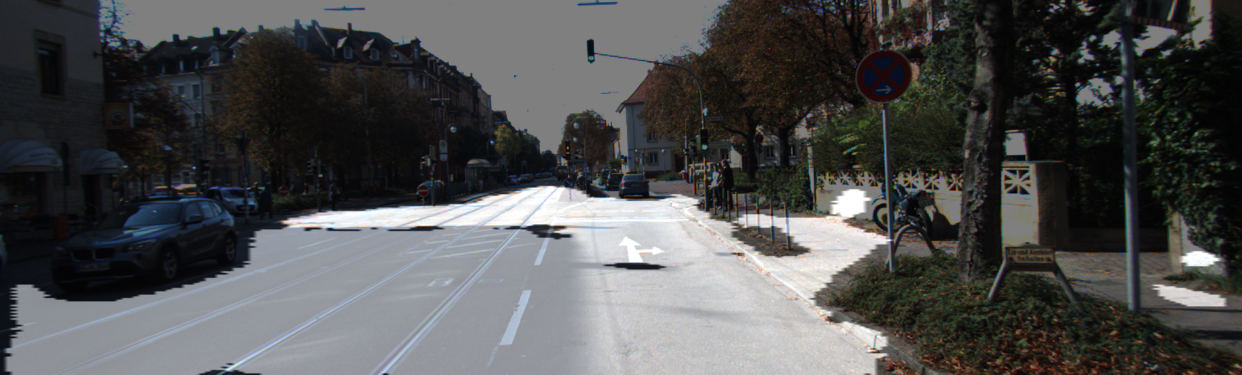

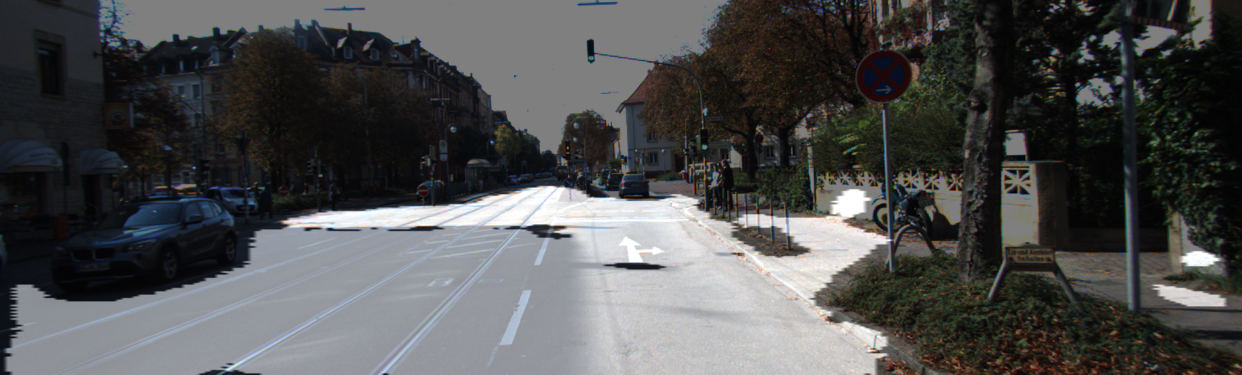

In [16]:
# u_net 학습한 모델 불러오기
unet_model = tf.keras.models.load_model(unet_model_path)
    
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

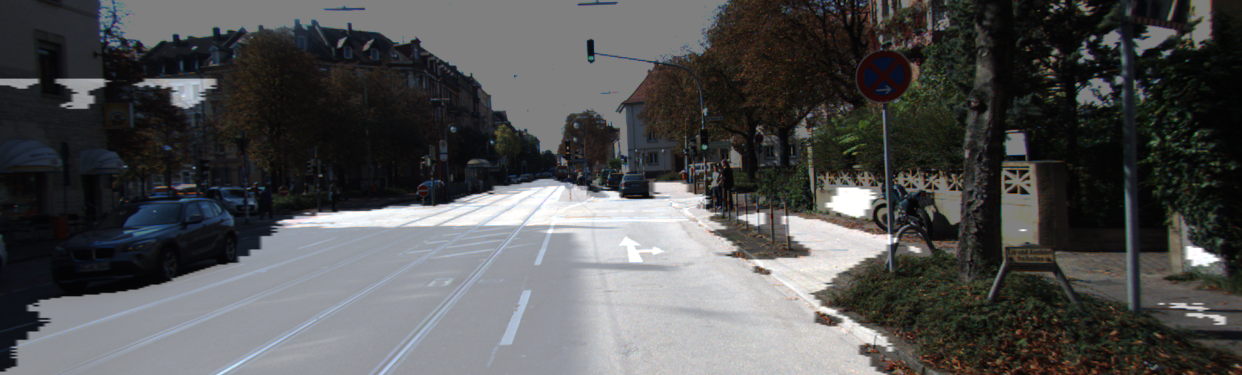

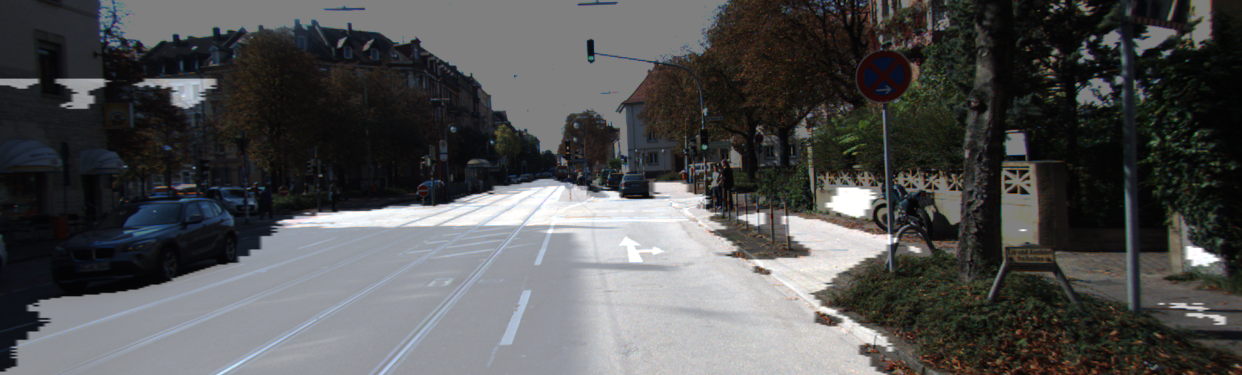

In [21]:
# u_net++ 학습한 모델 불러오기
unet_pp_model = tf.keras.models.load_model(unet_pp_model_path)

# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     unet_pp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

### IoU 및 시각화 비교

In [22]:
# IoU 계산
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

# get_output 확장
def get_output_upgrade(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

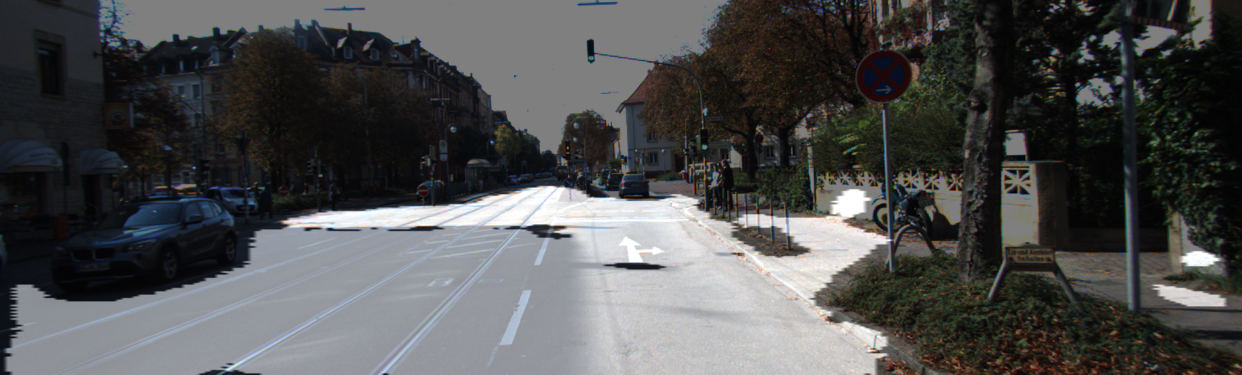

IoU : 0.849046


0.8490457741426316

In [23]:
# u_net 시각화 및 iou 계산
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output_upgrade(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

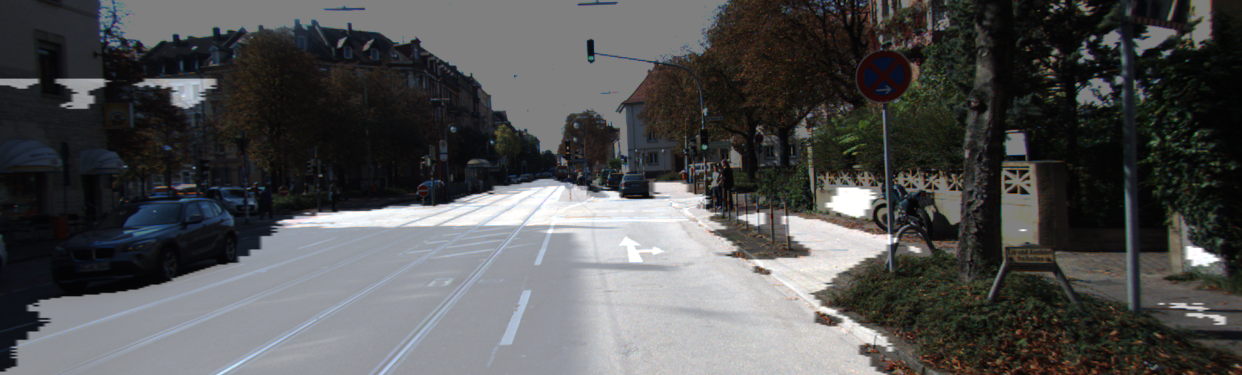

IoU : 0.841085


0.8410847267106927

In [24]:
# u_net++ 시각화 및 iou 계산
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output_upgrade(
     unet_pp_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

- U-Net과 U-Net++ 결과를 비교했을 때, 시각화 결과와 IoU 계산 결과가 동일하게 나왔다. U-Net++ 구현이 잘못된 건지 학습이 잘못된 건지 변수설정이 잘못된 건지 모르겠다. 시각화와 IoU 계산으로는 U-Net과 U-Net++ 성능을 비교할 수가 없었다.
- 광석님의 도움을 받아 잘못된 부분을 찾았다. 경로설정 시 U-Net과 U-Net++를 동일하게 설정해서 생긴 문제였다. 경로를 다시 설정해서 시각화와 IoU를 계산한 결과 시각적으로는 U-Net++를 적용한 경우가 더 깔끔하게 도로를 인식하는 것처럼 보여서 성능이 더 좋은 줄 알았으나 IoU 계산 결과를 봤을 때에는 U-Net은 0.849, U-Net++는 0.841로 u_Net의 성능이 아주 조금 더 좋았다.

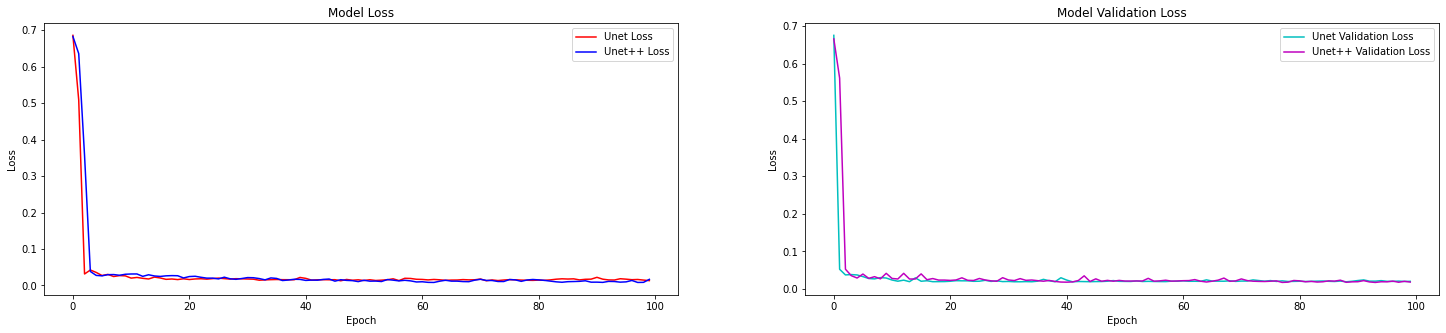

In [25]:
fig=plt.figure(figsize=(25,5))

plt.subplot(1,2,1)
plt.plot(history_unet.history['loss'], 'r')
plt.plot(history_unet_pp.history['loss'], 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Unet Loss', 'Unet++ Loss'], loc='upper right')

plt.subplot(1,2,2)
plt.plot(history_unet.history['val_loss'], 'c')
plt.plot(history_unet_pp.history['val_loss'], 'm')
plt.title('Model Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Unet Validation Loss', 'Unet++ Validation Loss'], loc='upper right')

- U-Net과 U-Net++ validation loss를 비교해봤을 때에도 크게 차이를 보이지 않았다. 학습과 관련해서 두 모델의 차이가 크게 없는 듯하다.

------

## 회고
1. U-Net을 통한 세그멘테이션 작업이 정상적으로 진행되었는가?  
U-Net 모델에 있어서는 KITTI 데이터셋 구성, U-Net 모델 훈련, 결과물을 시각화의 한 사이클을 정상 수행하였고 세그멘테이션 결과 이미지가 잘 나왔다.  
2. U-Net++ 모델이 성공적으로 구현되었는가?  
U-Net++ 모델을 혼자 구현하기가 어려워 구현되어 있는 코드를 많이 참고했다. 그렇게 구현한 코드로 학습도 진행하였고, 세그멘테이션 결과를 냈지만 처음에 U-Net과 결과가 똑같이 나와서 잘못된 점을 찾아보았다. 광석님의 도움을 받아 경로 설정 문제를 해결한 후 세그멘테이션까지 결과를 내기는 했으나 loss함수 설정에서 어려움을 겪었다. 이 부분에 있어서는 좀 더 공부가 필요하다.  
3. U-Net과 U-Net++ 두 모델의 성능이 정량적/정성적으로 잘 비교되었는가?  
U-Net과 U-Net++ 두 모델의 성능을 비교해봤을 때 정성적으로는 U-Net++가 더 깔끔하게 세그멘테이션되어 U-Net++ 모델의 성능이 더 좋다고 느껴졌다. 하지만 정량적으로 봤을 때, IoU 계산 결과가 U-Net이 조금 더 높아서 결과적으로 U-Net의 성능이 더 좋은 것으로 판단된다.  
4. 프로젝트를 진행하면서 느낀 점: U-Net++를 구현하는 것이 핵심인 프로젝트였는데, 그걸 혼자 힘드로 구현해내기가 굉장히 어려웠다. 결국 다른 사람의 코드를 참고했고 그 코드를 이해하기 위해 노력하는 것으로 프로젝트를 마무리해보았다. 스스로 구현해내지 못해서 아쉬웠고 경로 설정 실수 하나로 결과가 완전히 달라질 수 있어 항상 더 주의해서 코드를 구성해야 한다는 점을 느꼈다.

## Reference
- [U-Net++ 구조 참고](https://github.com/museonghwang/AIFFEL/blob/master/GoingDeeper_10/%5BGD_10%5D_Creating_an_improved_U_Net_model.ipynb)  
- [dice_coef_loss](https://github.com/MrGiovanni/UNetPlusPlus/blob/e145ba63862982bf1099cf2ec11d5466b434ae0b/keras/helper_functions.py#L37)  
- [bce_dice_loss에서 음수인 loss값 해결하기](https://github.com/MrGiovanni/UNetPlusPlus/issues/49)